# PRI: Building an Information Retrieval System using University Data

## Data preparation

### Filtering the dataset

This script will filter the University rankings dataset by the country of origin. In the .csv file 00_eu_country_codes.csv, we defined all the European country ISO codes. Using those codes, we can easily perform the filtering.


In [1]:
import pandas as pd

df = pd.read_csv("../datasets/00_eu_country_codes.csv")
country_codes = df["Country codes"].tolist()

df = pd.read_csv("../datasets/00_2024_QS_World_university_rankings.csv")
mask = df["Country Code"].isin(country_codes)

filtered_df = df[mask]

filtered_df.to_csv("../datasets/01_Universities_ranking_filtered.csv", index=False)

print("Filtering finished.")


Filtering finished.


## Enriching data

Next we started fetching the data for each university with different methods which will be explained as we go. However, the datasets we will be using are:

- 2024 University ranking (.csv file from Kaggle - used in **Filtering the dataset**)
- Wikipedia API to get the plain text of the Wikipedia page of that university
- WikiData API to get general university data 
- WikiData API to get the cities and coordinates where the universities are located 
- Wikipedia API to get the plain text of the Wikipedia page of that city

However, before doing so, we still needed to adjust the current dataset. Since some university names were written in their local language, we manually translated them to english, since we will be using the English Wikipedia and Wikidata API. Starting from the file 01_Universities_ranking_filtered.csv we get in the last step, we can create 01_Universities_ranking_filtered_renamed.csv.

For this purpose we renamed the old "Institution Name" to "Institution Name - WRONG" and created a new column with the heading "Institution Name" where we added the correct University names.


### University Wikidata

This script reads the english university names and fetches data for them from the Wikidata API. The most important thing we get with it is the ID of the actual Wikipedia page as well as confirmation that the Wikipedia page for that university exists.

In [4]:
import requests
from pandas import *
import json

base_url = "https://wikidata.org/w/api.php?action=wbgetentities&sites=enwiki&props=descriptions&languages=en&format=json"
csv_file_path = "../datasets/01_Universities_ranking_filtered_renamed.csv"
new_csv_file_path = "../datasets/02_Universities_with_wikidata.csv"

# Prepare dataset
data = read_csv(csv_file_path)
institution_name = data['Institution Name'].tolist()

# Results
results = []

for index, i in enumerate(institution_name):
    # fetch data for University
    try:
        print("Starting API call for: ", index, " ", i)
        url = base_url + "&titles=" + institution_name[index].replace(" ", "_")
        r = requests.get(url)
        request_payload = json.loads(r.content.decode())

        # check if university data is found and update the field
        if ("-1" not in request_payload["entities"].keys()):
            data.loc[index, 'Wikidata'] = (json.dumps(request_payload))
            print("Finished API call for: ", index, " ", i, " - OK")
        else:
            results.append(False)
            data.loc[index, 'Wikidata'] = "NOT FOUND"
            print("Finished API call for: ", index, " ", i, " - NOT FOUND")
    except Exception as ex:
        print("Failed API call for: ", index, " ", i, " with exception: ", ex)
        data.loc[index, "Wikidata"] = "ERROR"

# writing into the file
data.to_csv(new_csv_file_path, index=False)

print("Url don't exist count: " + str(results.count(False)))


Starting API call for:  0   University of Cambridge
Finished API call for:  0   University of Cambridge  - OK
Starting API call for:  1   University of Oxford
Finished API call for:  1   University of Oxford  - OK
Starting API call for:  2   Imperial College London
Finished API call for:  2   Imperial College London  - OK
Starting API call for:  3   ETH Zurich
Finished API call for:  3   ETH Zurich  - OK
Starting API call for:  4   UCL
Finished API call for:  4   UCL  - OK
Starting API call for:  5   University of Edinburgh
Finished API call for:  5   University of Edinburgh  - OK
Starting API call for:  6   Paris Sciences et Lettres University
Finished API call for:  6   Paris Sciences et Lettres University  - OK
Starting API call for:  7   University of Manchester
Finished API call for:  7   University of Manchester  - OK
Starting API call for:  8   École Polytechnique Fédérale de Lausanne
Finished API call for:  8   École Polytechnique Fédérale de Lausanne  - OK
Starting API call fo

**RESULTS:** Only 1 universities was not found, because it had the character & in it's name (Wageningen University & Research). Because of that we manually changed the '&' to '%26', and now all of the universities from Europe will be analysed.

### University Wikipedia plain text

This script reads the university's id from the Wikidata fetched in the last code chunk, then it fetches the Wikipedia page content by it's title. Finally, it parses the wikitext to plain text with the mwparserfromhell library.

In [3]:
import requests
import mwparserfromhell
import pandas as pd

csv_file_path = "../datasets/02_Universities_with_wikidata.csv"
new_csv_file_path = "../datasets/03_Universities_with_wikipedia_page.csv"
base_url = "https://en.wikipedia.org/w/api.php"

data = pd.read_csv(csv_file_path)
wikidata_list = data['Wikidata'].tolist()

skipped = 0

for index, wikidata in enumerate(wikidata_list):
    try:
        print("Retrieving wikipedia text for: ", index, end="")
        
        wikidata_id = list(json.loads(wikidata)['entities'].keys())[0]

        # Get Wikipedia Page ID from Wikidata ID
        wikidata_url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={wikidata_id}&format=json"
        r = requests.get(wikidata_url)
        wikidata_data = r.json()
        title = wikidata_data['entities'][wikidata_id]['sitelinks']['enwiki']['title']
        print(f" {title}")

        # Get Wikipedia Page Text using Page ID
        wikipedia_url = f"https://en.wikipedia.org/w/api.php?action=query&titles={title}&prop=revisions&rvprop=content&format=json"
        r = requests.get(wikipedia_url)
        wikipedia_data = r.json()
        page_id = list(wikipedia_data['query']['pages'].keys())[0]
        page_text = wikipedia_data['query']['pages'][page_id]['revisions'][0]['*']

        # page_text is in wikitext format, so it needs to be converted to plain text
        parsed_wikitext = mwparserfromhell.parse(page_text)
        plain_text = parsed_wikitext.strip_code()
        data.loc[index, 'Wikipedia Text'] = plain_text
    except Exception as ex: 
        print("\nFailed API call for: ", index, " with exception: ", ex)
        data.loc[index, "Wikipedia Text"] = "ERROR"
        skipped += 1

#write to file
data.to_csv(new_csv_file_path, index=False)
print("Wikipedia text NOT FOUND for: ", skipped, " universities.")

Retrieving wikipedia text for:  0 University of Cambridge


/var/folders/fq/l0m22dp153jb9c4b2x89p36m0000gp/T/ipykernel_4108/905230333.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'The University of Cambridge is a public collegiate research university in Cambridge, England. Founded in 1209, the University of Cambridge is the world's third-oldest university in continuous operation. The university's founding followed the arrival of scholars who left the University of Oxford for Cambridge after a dispute with local townspeople. The two ancient English universities, although sometimes described as rivals, share many common features and are often jointly referred to as Oxbridge. In 1231, 22 years after its founding, the university was recognised with a royal charter granted by King Henry III.

The University of Cambridge includes 31 semi-autonomous constituent colleges and over 150 academic departments, faculties, and other institutions organised into six schools. All of t

Retrieving wikipedia text for:  1 University of Oxford
Retrieving wikipedia text for:  2 Imperial College London
Retrieving wikipedia text for:  3 ETH Zurich
Retrieving wikipedia text for:  4 UCL
Retrieving wikipedia text for:  5 University of Edinburgh
Retrieving wikipedia text for:  6 Paris Sciences et Lettres University
Retrieving wikipedia text for:  7 University of Manchester
Retrieving wikipedia text for:  8 École Polytechnique Fédérale de Lausanne
Retrieving wikipedia text for:  9 Technical University of Munich
Retrieving wikipedia text for:  10 Polytechnic Institute of Paris
Retrieving wikipedia text for:  11 King's College London
Retrieving wikipedia text for:  12 London School of Economics
Retrieving wikipedia text for:  13 Delft University of Technology
Retrieving wikipedia text for:  14 University of Amsterdam
Retrieving wikipedia text for:  15 Ludwig Maximilian University of Munich
Retrieving wikipedia text for:  16 University of Bristol
Retrieving wikipedia text for:  17 

**RESULTS:** All university Wikipedia pages were retrieved successfully.

### University cities wikipedia plaintext

This script reads from the WikiData data and searches for references for the city in which the university is based. 

It searches for one of the following relationships:
- located in the administrative territorial, entity P131

If it finds a relationship it will use the same logic for fetching Wikipedia page plain text as before, for that city.

In [4]:
import requests
import mwparserfromhell
from pandas import *
import json

base_url = "https://en.wikipedia.org/w/api.php"
wikidata_base_url = "https://www.wikidata.org/w/rest.php/wikibase/v0/entities/items/"
csv_file_path = "../datasets/03_Universities_with_wikipedia_page.csv"
new_csv_file_path = "../datasets/04_Universities_with_city_wikipedia_page.csv"

# Prepare dataset
data = read_csv(csv_file_path)
university_wikidata = data['Wikidata'].tolist()

# Results
results = []

for index, uni_wikidata in enumerate(university_wikidata):
    try:
        print("Starting API call for: ", index)

        # get University wikidata from file
        wikidata_json = json.loads(uni_wikidata)
        wikidata_json = wikidata_json["entities"]
        university_id = list(wikidata_json.keys())[0]

        # Get the whole wikidata page for university
        response_body = requests.get(
            wikidata_base_url + university_id,
        ).json()

        university_relations = response_body["statements"]
        university_relations_keys = list(university_relations.keys())

        # Get the city wikidata if the relationship to the city exists
        # TODO check what other relations there are because some dont have this one, but have like location
        
        possible_relations_list = ["P131", "P276"]
        relation_found = False
        
        for rel in possible_relations_list:
            if (rel in university_relations_keys):
                relation_found = True
                
                city_id = university_relations[rel][0]["value"]["content"]
                print("Found city - Starting API call for: ", city_id)

                city_response_body = requests.get(
                    wikidata_base_url + city_id,
                ).json()

                city_name = city_response_body["labels"]["en"]
                print("Found city wikidata - Starting API call for: ", city_name)

                # Get Wikipedia Page Text using the city's title
                wikipedia_url = f"https://en.wikipedia.org/w/api.php?action=query&titles={city_name}&prop=revisions&rvprop=content&format=json"
                r = requests.get(wikipedia_url)
                wikipedia_data = r.json()
                page_id = list(wikipedia_data['query']['pages'].keys())[0]
                page_text = wikipedia_data['query']['pages'][page_id]['revisions'][0]['*']

                # page_text is in wikitext format, we have to convert it to plain text
                parsed_wikitext = mwparserfromhell.parse(page_text)
                plain_text = parsed_wikitext.strip_code()
                data.loc[index, 'City wikipedia text'] = plain_text
            
        if relation_found is False:
            results.append(False)
            data.loc[index, 'City wikipedia text'] = "NOT FOUND"
            print("Finished API call for: ", index, " - NOT FOUND")
    except Exception as ex:
        print("Unexpected error for: ", index, " with exception: ", ex)
        data.loc[index, "City wikipedia text"] = "ERROR"

# writing into the file
data.to_csv(new_csv_file_path, index=False)

print("Url don't exist count: " + str(results.count(False)))


Starting API call for:  0
Found city - Starting API call for:  Q23112
Found city wikidata - Starting API call for:  Cambridgeshire


/var/folders/fq/l0m22dp153jb9c4b2x89p36m0000gp/T/ipykernel_4108/3941682061.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cambridgeshire (abbreviated Cambs.) is a ceremonial county in the East of England and East Anglia. It is bordered by Lincolnshire to the north, Norfolk to the north-east, Suffolk to the east, Essex and Hertfordshire to the south, and Bedfordshire and Northamptonshire to the west. The largest settlement is the city of Peterborough, and the city of Cambridge is the county town.

The county has an area of  and a population of 852,523. Peterborough (179,349) and Cambridge (145,674), located in the north-west and south respectively, are by far the largest settlements. The remainder of the county is rural, and contains the city of Ely (20,112) and towns such as Wisbech and St Neots. Cambridgeshire contains six local government districts; five are part of a two-tier non-metropolitan county also c

Found city - Starting API call for:  Q350
Found city wikidata - Starting API call for:  Cambridge
Starting API call for:  1
Found city - Starting API call for:  Q34217
Found city wikidata - Starting API call for:  Oxford
Found city - Starting API call for:  Q34217
Found city wikidata - Starting API call for:  Oxford
Starting API call for:  2
Found city - Starting API call for:  Q188801
Found city wikidata - Starting API call for:  Royal Borough of Kensington and Chelsea
Found city - Starting API call for:  Q86088281
Found city wikidata - Starting API call for:  South Kensington Campus, Imperial College London
Unexpected error for:  2  with exception:  'revisions'
Starting API call for:  3
Found city - Starting API call for:  Q72
Found city wikidata - Starting API call for:  Zürich
Found city - Starting API call for:  Q72
Found city wikidata - Starting API call for:  Zürich
Starting API call for:  4
Finished API call for:  4  - NOT FOUND
Starting API call for:  5
Found city - Starting A

**RESULTS**: All university cities names from WikiData were successfully retrieved.

### University Coordinates Wikipedia Plain Text
This script searches for coordinate information related to the universities from WikiData data.

It searches for one of the following relationships:
- Latitude, entity P625
- Longitude, entity P625

If it finds coordinate information, it uses a similar logic as before to fetch Wikipedia page plain text for the corresponding location based on the coordinates.

In [ ]:
csv_final_file_path = "../datasets/06_Universities_ranking_filtered_with_coordinates.csv"

# Get the coordinates if the relationship exists
if ("P625" in university_relations_keys):
    latitude = university_relations["P625"][0]["value"]["content"]["latitude"]
    longitude = university_relations["P625"][0]["value"]["content"]["longitude"]

    print("Found coordinates - Starting API call for: ", (latitude, longitude))

    # Update the 'latitude' and 'longitude' columns in the DataFrame
    data.loc[index, 'Latitude'] = latitude
    data.loc[index, 'Longitude'] = longitude
else:
    # If coordinates not found, set 'Latitude' and 'Longitude' to None
    data.loc[index, 'Latitude'] = None
    data.loc[index, 'Longitude'] = None
    print("Finished API call for: ", index, " - NOT FOUND")
    
# Writing into the file
data.to_csv(csv_final_file_path, index=False)

print("Coordinates not found count: " + str(data['Latitude'].isnull().sum()))

**RESULTS**: All university coordinates from WikiData were successfully retrieved.

## Data analysis

Stats before cleaning data:
- Unis with at least one column missing:70

In [ ]:
raw_data_path = '../datasets/00_2024_QS_World_university_rankings.csv'
cleaned_data_path = '../datasets/04_Universities_with_city_wikipedia_page.csv'

In [ ]:
# Returns a list of universities and the columns that they are missing(missing value)
import pandas as pd

df = pd.read_csv(cleaned_data_path)

if 'Institution Name' in df.columns:
    missing_values_by_uni = {}

    # Iterate through rows and group missing values by uni
    for index, row in df.iterrows():
        university_name = row['Institution Name']
        missing_columns = [column for column in df.columns if column != 'Institution Name' and pd.isnull(row[column])]
        
        # Store only universities that have a missing column
        if university_name not in missing_values_by_uni and len(missing_columns) > 0:
            missing_values_by_uni[university_name] = []
            missing_values_by_uni[university_name].extend(missing_columns)

    # Print missing values grouped by university name
    for university, missing_columns in missing_values_by_uni.items():
        print(f"Missing values for {university} are: {', '.join(missing_columns)}")
    
    print("Number of universities that have at least one missing value:", len(missing_values_by_uni))
    
    # Get 5 columns that have most missing values (results using full_list.csv): 
    from collections import Counter
    columns = missing_values_by_uni.values()
    result = []
    for l in columns:
        result.extend(l)
        
    most_common_missing_columns = Counter(result).most_common(5)
    print([name for name,_ in most_common_missing_columns])
    print(most_common_missing_columns)
    
    # Delete the 5 columns which have most missing values:
    columns_to_delete = [name for name,_ in most_common_missing_columns]
    df.drop(columns=columns_to_delete, inplace=True)
    output_file_path = 'datasets/cleaned_full_list.csv'
    df.to_csv(output_file_path, index=False)
    
    # Get 10 universities which have most missing values/columns
    count_missing_values_by_uni = {}
    for uni in missing_values_by_uni:
        count_missing_values_by_uni[uni] = len(missing_values_by_uni[uni])
    top_10_unis = dict(sorted(count_missing_values_by_uni.items(), key=lambda item: item[1], reverse=True)[:10])
    print(top_10_unis)
    
    # Delete the 10 unis
    unis_name = [uni for uni in top_10_unis]
    print(unis_name)
    mask = ~df['Institution Name'].isin(unis_name)
    filtered_data = df[mask]
    filtered_data.to_csv(output_file_path, index = False)
else:
    print("Error: 'Institution Name' column not found in the DataFrame.")

## Data Visualization

The first chart shows that the focus of this project is in the European universities, by displaying their distribution over Europe.


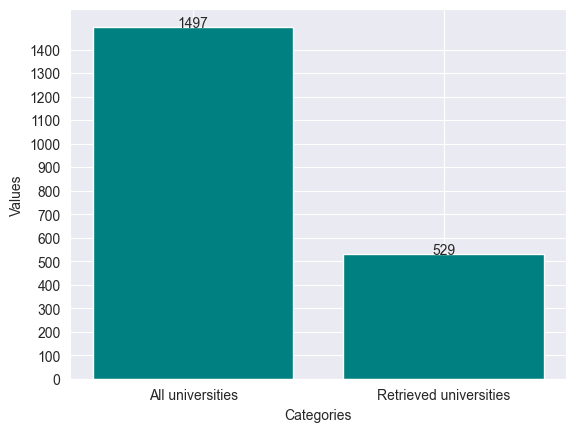

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Get raw data (from Kaggle)
csv_file_path = "../datasets/00_2024_QS_World_university_rankings.csv"
raw_data = pd.read_csv(csv_file_path)
total_uni_list = raw_data['Institution Name'].tolist()

total_number_uni = len(total_uni_list) - 1
csv_file_path = "../datasets/01_Universities_ranking_filtered_cleaned.csv"
retrieved_data = pd.read_csv(csv_file_path)
retrieved_uni_list = retrieved_data['Institution Name'].tolist()
retrieved_number_uni = len(retrieved_uni_list)
#print(total_number_uni,retrieved_number_uni)

data = {
    'Categories': ['All universities', 'Retrieved universities'],
    'Values': [total_number_uni, retrieved_number_uni]
}

df = pd.DataFrame(data)
categories = df['Categories']
values = df['Values']

plt.bar(categories, values, color='teal')

plt.yticks(range(0, max(values) + 1, 100))

for i in range(len(categories)):
        plt.text(i, values[i], values[i], ha = 'center')

plt.xlabel('Categories')
plt.ylabel('Values')

plt.show()
plt.savefig('all_vs_retrieved_unis.png')

The second chart presented is a bar chart that illustrates the number of universities per country, allowing to quickly grasp the distribution of universities across different countries. This visual representation aids in identifying countries with a significant presence of the best universities in Europe.

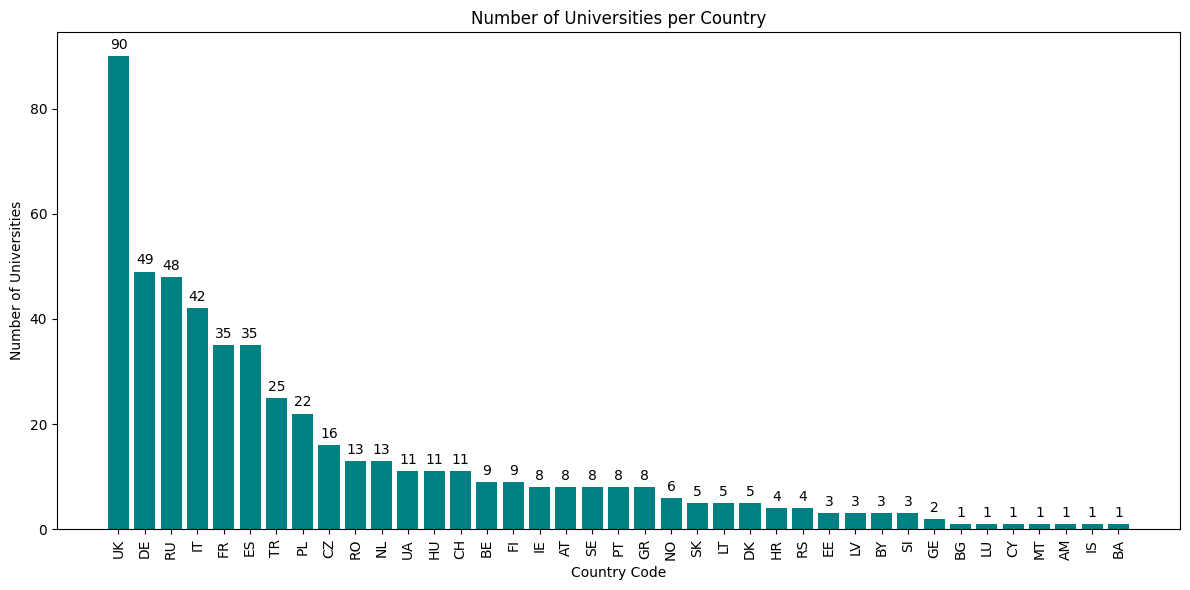

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../datasets/01_Universities_ranking_filtered.csv")

country_counts = df['Country Code'].value_counts().reset_index()
country_counts.columns = ['Country Code', 'Number of Universities']

country_counts = country_counts.sort_values(by='Number of Universities', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(country_counts['Country Code'], country_counts['Number of Universities'], color='teal')
plt.xlabel('Country Code')
plt.ylabel('Number of Universities')
plt.title('Number of Universities per Country')
plt.xticks(rotation=90)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("../img/number_of_universities_per_country.png")
plt.show()

Moving on to geographic visualization, the next chart is a map that displays the cities where universities are located, along with a heatmap that visualizes the distribution of universities across Europe. Each city is pinpointed on the map, providing a clear spatial perspective of university distribution, while the heatmap helps identify clusters of universities in specific regions.

In [33]:
import folium

csv_file_path = "../datasets/06_Universities_ranking_filtered_with_coordinates.csv"
data = pd.read_csv(csv_file_path)

# Map of Europe (mostly)
m = folium.Map(location=[50, 10], zoom_start=4) 

def add_pinpoint(row):
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Institution Name'],
            icon=folium.Icon(color='lightblue', icon='university', prefix='fa'),  
        ).add_to(m)

data.apply(add_pinpoint, axis=1)

m.save('../img/universities_map.html')

![alt text](../img/uni_map.png)

In [ ]:
from folium.plugins import HeatMap
import pandas as pd

csv_file_path = "../datasets/06_Universities_ranking_filtered_with_coordinates.csv"
data = pd.read_csv(csv_file_path)

m = folium.Map(location=[50, 10], zoom_start=4)  

locations = data[['Latitude', 'Longitude']].dropna().values.tolist()
HeatMap(locations).add_to(m)

m.save('../img/universities_heatmap.html')

![alt text](../img/uni_heatmap.png)

To assess changes in university rankings over time, this bar chart is used to compare the rankings of universities in 2024 (2023/2024) and 2023 (2022/2023). This dynamic visualization highlights universities that have experienced rank changes, such as improvements or declines, between the two years.

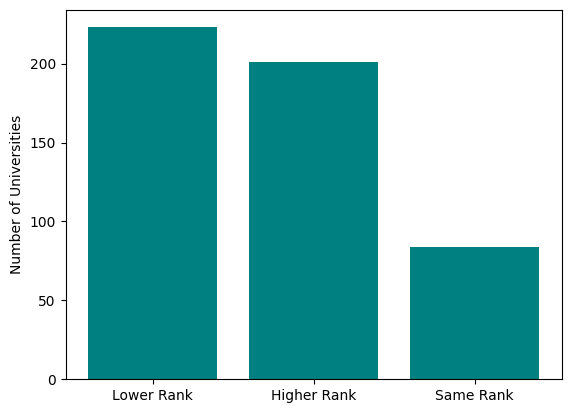

In [34]:
# Normalization of the ranks
import pandas as pd
import numpy as np

df = pd.read_csv("../datasets/01_Universities_ranking_filtered.csv")


def clean_and_format_rank(rank_value):
    if isinstance(rank_value, str):
        rank_value = rank_value.replace('=', '').replace('+', '')
        if '-' in rank_value:
            rank_value = rank_value.split('-')[0]
        return int(rank_value)
    elif np.isnan(rank_value):
        return None  
    else:
        return int(rank_value)

df['2024 RANK'] = df['2024 RANK'].apply(clean_and_format_rank)
df['2023 RANK'] = df['2023 RANK'].apply(clean_and_format_rank)
df.to_csv("01_Universities_ranking_filtered_cleaned.csv", index=False)


# Plot Rank Comparison 2024 vs 2023
import matplotlib.pyplot as plt

df['Rank Category'] = pd.cut(df['2024 RANK'] - df['2023 RANK'],
                             bins=[float('-inf'), -1, 1, float('inf')],
                             labels=["Lower Rank", "Same Rank", "Higher Rank"])  # Updated labels

rank_counts = df['Rank Category'].value_counts()

plt.bar(rank_counts.index, rank_counts.values, color=['teal', 'teal', 'teal'] )

plt.ylabel('Number of Universities')
plt.savefig("../img/rank_comparison_plot.png")
plt.show()

For a more qualitative analysis, the next word clouds are generated from the Wikipedia text from all the universities. These word clouds visually represent the most frequently occurring terms in the text, giving us insights into the key themes and topics associated with these institutions. This visualization aids in identifying common areas of focus or interest across universities.

In [1]:
# Set up environment
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import string
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

data_path = "../datasets/04_Universities_with_city_wikipedia_page.csv"
df = pd.read_csv(data_path)

wiki_texts = df["City wikipedia text"].tolist()
text = " ".join(wiki_texts)

# Pre-processing data
# Turn all the text into lowercase, remove punctuation, tokenize it, to remove numbers and stopwords, and lemmatize it
text = text.lower().translate(str.maketrans('', '', string.punctuation))
tokens = nltk.word_tokenize(text)
tokens = [word for word in tqdm(tokens) if word.isalpha()]
tokens = [word for word in tqdm(tokens) if word not in nltk.corpus.stopwords.words('english')]
wnl = WordNetLemmatizer()
tokens = [wnl.lemmatize(word) for word in tqdm(tokens)]
#print(tokens)

# Count word frequencies
from collections import Counter
token_frequency = Counter(tokens)
#print(token_frequency)

# Create word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

most_common_words = token_frequency.most_common(100)
wordcloud_dict = {key: value for key, value in most_common_words}
#print(wordcloud_dict)

wordcloud = WordCloud(width = 800, height = 600, background_color = 'white').generate_from_frequencies(wordcloud_dict)
wordcloud.to_file("../wordcloud_city.png")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

KeyboardInterrupt: 

Now, to analyse the size and age of each university, this graph has the number of universities falling into different size categories (XL, L, M, S) while considering their age, which ranges from new (Category 1) to older (Category 5). The teal-colored bars represent the count of universities in each size category, with age categories distinguished by different shades within each bar. This visualization helps us understand how university sizes vary across different age categories.

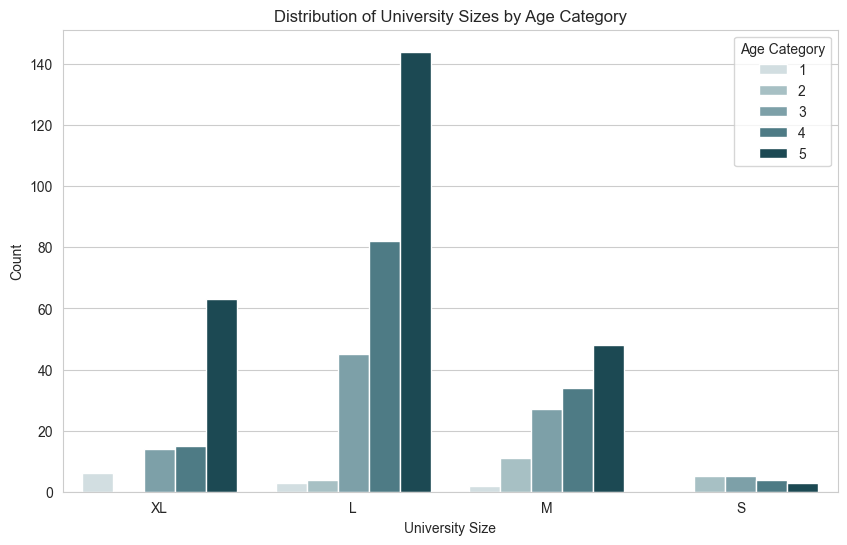

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../datasets/01_Universities_ranking_filtered_cleaned.csv')

size_order = ['XL', 'L', 'M', 'S']
age_order = [1, 2, 3, 4, 5]
palette = ["#D0E0E3", "#A2C4C9", "#76A5AF", "#45818E", "#134F5C"]

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='SIZE', hue='AGE', order=size_order, hue_order=age_order, palette=sns.color_palette(palette, 5))

plt.xlabel('University Size')
plt.ylabel('Count')
plt.title('Distribution of University Sizes by Age Category')

plt.legend(title='Age Category', loc='upper right')
plt.show()

Finally, the last graph is a bar chart where can be made observations about what is the score mode.

<Axes: ylabel='Frequency'>

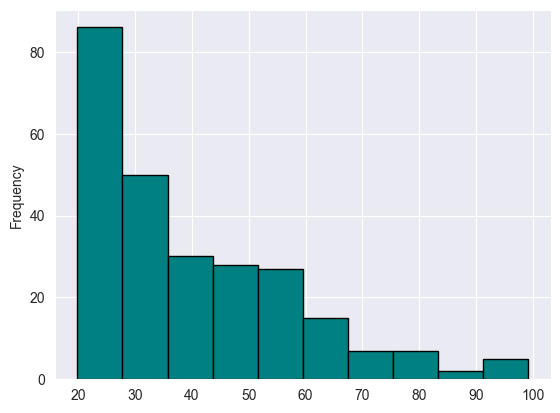

In [2]:
import pandas as pd
df = pd.read_csv("../datasets/01_Universities_ranking_filtered.csv")

filtered_values = df['Overall SCORE'][df['Overall SCORE'] != '-']
filtered_values = pd.to_numeric(filtered_values, errors='coerce')
filtered_values.plot(kind='hist', edgecolor='black', color='teal')

## Storage

At this point the only thing left is to store all the data in an appropriate format. For our use case we decided to use a JSON file.

In [14]:
import json
import pandas as pd

csv_file_path = "../datasets/04_Universities_with_city_wikipedia_page.csv"
output_file_path = "../datasets/05_University_documents.json"

df = pd.read_csv(csv_file_path)
data = df.to_dict(orient="records")

with open(output_file_path, 'w') as json_output:
    json.dump(data, json_output)

print("Finished creating JSON file.")

Finished creating JSON file.
